# RAG operations in pixeltable

In this tutorial, we'll explore Pixeltable's flexible handling of RAG operations on a collection of PDF documents. In a traditional RAG workflow, such operations might be implemented as a Python script that runs on a periodic schedule or in response to certain events. In Pixeltable, as with everything else, they are implemented as persistent table operations that update incrementally as new data becomes available. 

In [7]:
import pathlib
import pandas as pd

# collect the document paths from the directory
document_dir = pathlib.Path('~/Downloads/Documents_Questions/').expanduser()
document_paths = [str(path) for path in list(document_dir.glob('*.pdf'))]
start_paths = document_paths[:4]
adddd_paths = document_paths[4:]
start_paths

['/Users/orm/Downloads/Documents_Questions/Generative AI Use Cases for Industries and Enterprises.pdf',
 '/Users/orm/Downloads/Documents_Questions/ThompsonReutersAmazon.pdf',
 '/Users/orm/Downloads/Documents_Questions/CompuStatCompanyResearchShopify.pdf',
 '/Users/orm/Downloads/Documents_Questions/ArgusResearch_Shopify.pdf']

In [8]:
# example questions and ground truth answers
ground_truth_path = [str(path) for path in document_dir.glob('*xlsx')][0]
ground_truth_df = pd.read_excel(ground_truth_path, index_col=0)
ground_truth_df

,Question,correct_answer
S. No.,,
1,What is JPMorgan's net income for the second q...,$14.5 Billion
2,What JPMorgan's net income per share for secon...,$4.75 per share
3,What is the change in JPMorgan debit and credi...,The sales volume was up by 7 %
4,What was the net revenue reported for 2Q23 for...,"$41, 307 Million"
5,What was the net revenue reported for 2Q23 for...,"$41, 307 Million"
6,What was the net revenue reported for second q...,"$41, 307 Million"
7,What was the net income for the second quarter...,$ 1226 million
8,What was the net income for the 2Q23 for JPM A...,$ 1226 million
9,What is JP Morgan's banking and asset manageme...,$10.9 Billion up 68%


# Outline 

A RAG system comprises two pipelines: preprocessing and querying

1. Preprocessing:
    1.1. Loading documents and splitting them into smaller fragments, or chunks.
    1.2. Using an embedding model, compute a vector embedding for each chunk, Build a vector index over these vectors for low latency lookups at question time.

2. Querying,  for each question Q:
    2.1 From the preprocessed chunks, locate the top-10, or top-k most relevant context chunks for Q, via a top-k vector lookup.
    2.2 Together with the question Q, use the context chunks to construct a large prompt, Use this enriched prompt as a question input to a Large Language Model to generate an answer

Below, we show how to implement both stages with pixeltable.

## 1. Preprocessing

In Pixeltable all data lives in tables, and documents are a type of data.

Tables are persistent containers meant to be the store or record for your data. Since we are starting from scratch, we will start with an empty table `doc_table` with a single column, `document`:

In [12]:
import pixeltable as pxt
pxt.drop_table('doc_chunks', ignore_errors=True)
pxt.drop_table('doc_table', ignore_errors=True)
doc_table = pxt.create_table('doc_table', {'document': pxt.DocumentType()})
doc_table

Created table `doc_table`.


Column Name,Type,Computed With
document,document,


Next, we load a few documents as rows into the table, with an `insert` operation

In [13]:
doc_table.insert([{'document': doc} for doc in start_paths])

Inserting rows into `doc_table`: 4 rows [00:00, 1011.65 rows/s]
Inserted 4 rows with 0 errors.


UpdateStatus(num_rows=4, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

document
""
""
""
""

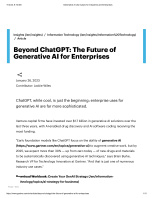
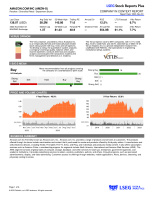
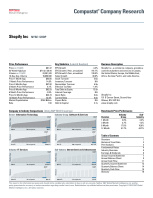
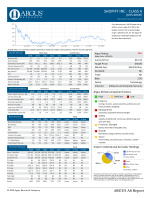

In [14]:
doc_table.show()

In RAG, it is often necessary to decompose long documents into smaller units, or chunks, rather than treating each document as a single entitiy. 
For convenience, Pixeltable offers a `DocumentSplitter` that breaks documents into chunks with multiple user-configurable options controling where to split these chunks

In [15]:
from pixeltable.iterators.document import DocumentSplitter
for i, chunk in enumerate(DocumentSplitter(document_paths[0], separators='paragraph', metadata='page')):
    if i > 5:
        break
    print(chunk)

{'text': '11/4/23, 9:10 AM\nGenerative AI Use Cases for Industries and Enterprises\n', 'page': 0}
{'text': 'https://www.gartner.com/en/articles/beyond-chatgpt-the-future-of-generative-ai-for-enterprises\n1/11\n', 'page': 0}
{'text': 'Insights (/en/insights) /  Information Technology (/en/insights/Information%20Technology)\n', 'page': 0}
{'text': '/  Article\n', 'page': 0}
{'text': 'Beyond ChatGPT: The Future of\nGenerative AI for Enterprises\n', 'page': 0}
{'text': 'ChatGPT, while cool, is just the beginning; enterprise uses for\n', 'page': 0}


In RAG, we compute a vector embedding for each text chunk, and we need to track the correspondence between individual text chunks and their vectors.  Using pixeltable we could create a new table with these chunks and vectors, but when new documents are added or removed from the document table, we would need extra tooling to mark their correspondence and to keep corresponding chunks in sync with their corresponding documents. 

Pixeltable automates these operations through `views`, A `view`, in addition to holding the chunk texts in this case, will stay in sync with the document table: when new documents get added to the document table, the corresponding chunks are added to the view.  

We use `create_view` below to benefit from staying in sync.

In [19]:
pxt.drop_table('doc_chunks', ignore_errors=True)
iterator_args = {
    'document': doc_table.document,
    'separators': 'paragraph',
    'metadata': 'page',
}
doc_chunks = pxt.create_view(f'doc_chunks', doc_table, iterator_class=DocumentSplitter, iterator_args=iterator_args)
doc_chunks

Inserting rows into `doc_chunks`: 1601 rows [00:00, 8627.52 rows/s]
Created view `doc_chunks` with 1601 rows, 0 exceptions.


Column Name,Type,Computed With
pos,int,
text,string,
page,int,
document,document,


`doc_chunks` behaves much like a table, but already includes data because `doc_table` already holds documents, and all views are kept in sync with their tables.  Also note that the view includes columns from the document splitter, and also a reference `document` to the original document where the chunks came from.



We can select the first 2 chunks from each document using common dataframe operations, in order to get a feel for the chunks extracted:

pos,text,page,document
0,"11/4/23, 9:10 AM\nGenerative AI Use Cases for Industries and Enterprises\n",0,
1,https://www.gartner.com/en/articles/beyond-chatgpt-the-future-of-generative-ai-for-enterprises\n1/11\n,0,
0,Last Close\n138.07 (USD)\n,0,
1,2023 November 02\nNASDAQ Exchange\n,0,
0,Shopify Inc\nNYSE: SHOP\n,0,
1,Price Performance\n,0,
0,®\nSHOPIFY INC - CLASS A\n,0,
1,(NYS:SHOP)\n,0,

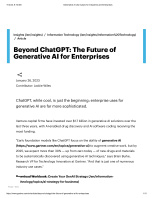
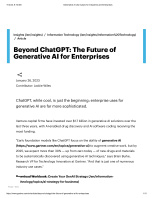
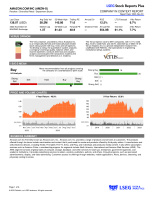
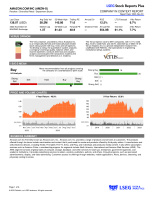
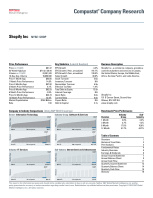
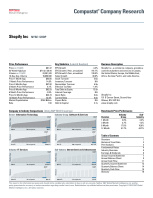
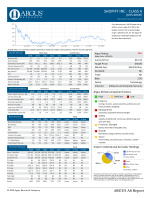
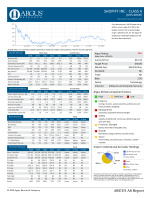

In [20]:
doc_chunks.where(doc_chunks.pos < 2).show()

In this case, the paragraphs seem like they are a bit small, so we may create other views to explore other chunking options.

In [22]:
pxt.drop_table('doc_chunks2', ignore_errors=True)
iterator_args = {
    'document': doc_table.document,
    'separators': 'token_limit',
    'limit': 500
}
doc_chunks2 = pxt.create_view(f'doc_chunks2', doc_table, iterator_class=DocumentSplitter, iterator_args=iterator_args)
doc_chunks2


Inserting rows into `doc_chunks2`: 62 rows [00:00, 5950.18 rows/s]
Created view `doc_chunks2` with 62 rows, 0 exceptions.


Column Name,Type,Computed With
pos,int,
text,string,
document,document,


pos,text,document
0,"11/4/23, 9:10 AM\nGenerative AI Use Cases for Industries and Enterprises\nhttps://www.gartner.com/en/articles/beyond-chatgpt-the-future-of-generative-ai-for-enterprises\n1/11\nInsights (/en/insights) / Information Technology (/en/insights/Information%20Technology)\n/ Article\nBeyond ChatGPT: The Future of\nGenerative AI for Enterprises\nChatGPT, while cool, is just the beginning; enterprise uses for\ngenerative AI are far more sophisticated.\n\nJanuary 26, 2023\nContributor: Jackie Wiles\nVenture capital firms have invested over $1.7 billion in generative AI solutions over the\nlast three years, with AI-enabled drug discovery and AI software coding receiving the\nmost funding. \n""Early foundation models like ChatGPT focus on the ability of generative AI\n(https://www.gartner.com/en/topics/generative-ai) to augment creative work, but by\n2025, we expect more than 30% — up from zero today — of new drugs and materials\nto be systematically discovered using generative AI techniques,"" says Brian Burke,\nResearch VP for Technology Innovation at Gartner. ""And that is just one of numerous\nindustry use cases.""\nDownload Workbook: Create Your GenAI Strategy (/en/information-\ntechnology/topics/ai-strategy-for-business)\nPrivacy - Terms\n11/4/23, 9:10 AM\nGenerative AI Use Cases for Industries and Enterprises\nhttps://www.gartner.com/en/articles/beyond-chatgpt-the-future-of-generative-ai-for-enterprises\n2/11\nFive industry use cases for generative AI\nGenerative AI can explore many possible designs of an object to find the right or most\nsuitable match. It not only augments and accelerates design in many fields, it also has\nthe potential to ""invent"" novel designs or objects that humans may have missed\notherwise. \nMarketing and media are already feeling the impacts of generative AI. Gartner\nexpects:\nBy 2025, 30% of outbound marketing messages from large organizations will be\nsynthetically generated, up from less than 2% in 2022. \nBy 2030, a major blockbuster film will be released with 90% of the film generated\nby AI (from text to video",
1,"), from 0% of such in 2022.\nStill, AI innovations (/en/articles/what-s-new-in-artificial-intelligence-from-the-\n2023-gartner-hype-cycle) are generally accelerating, creating numerous use cases\nfor generative AI in various industries, including the following five.\nNo. 1: Generative AI in drug design\nA 2010 study showed the average cost of taking a drug from discovery to market was\nabout $1.8 billion, of which drug discovery costs represented about a third, and the\ndiscovery process took a whopping three to six years. Generative AI has already been\nused to design drugs for various uses within months, offering pharma significant\nopportunities to reduce both the costs and timeline of drug discovery.\nView Resource Center: What Generative AI Means for Business\n(/en/insights/generative-ai-for-business)\nNo. 2: Generative AI in material science\nGenerative AI is impacting the automotive, aerospace, defense, medical, electronics\nand energy industries by composing entirely new materials targeting specific physical\nproperties. The process, called inverse design, defines the required properties and\ndiscovers materials likely to have those properties rather than relying on serendipity\n11/4/23, 9:10 AM\nGenerative AI Use Cases for Industries and Enterprises\nhttps://www.gartner.com/en/articles/beyond-chatgpt-the-future-of-generative-ai-for-enterprises\n3/11\nto find a material that possesses them. The result is to find, for example, materials that\nare more conductive or greater magnetic attraction than those currently used in\nenergy and transportation — or for use cases where materials need to be resistant to\ncorrosion.\nNo. 3: Generative AI in chip design\nGenerative AI can use reinforcement learning (a machine learning technique) to\noptimize component placement in semiconductor chip design (floorplanning),\nreducing product-development life cycle time from w
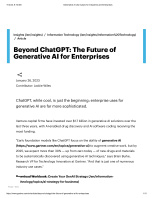
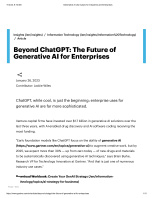
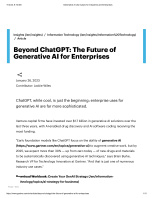
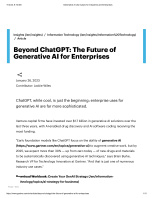
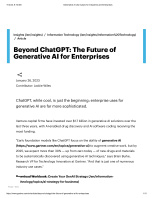
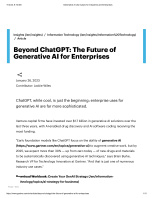
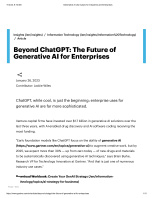
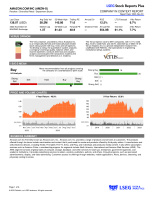
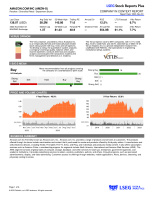
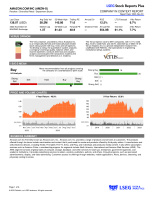
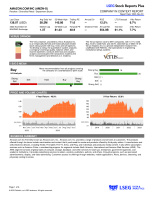
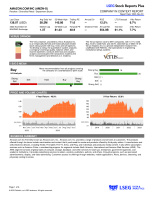
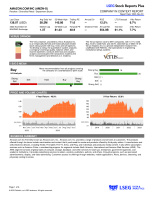
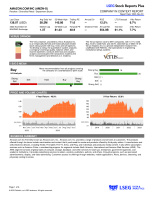
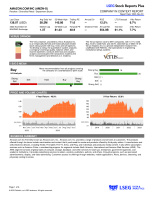
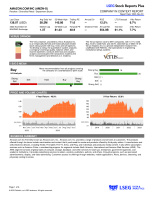
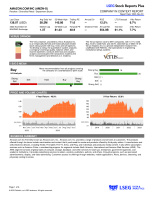
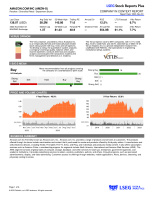
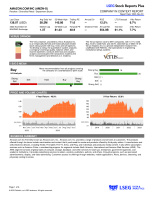
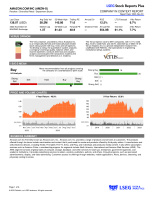

In [23]:
doc_chunks2.show()

### 1.2 Compute vector embeddings and index chunks

In order to offer efficient lookups of relevent chunks, pixeltable offers indexing. Indexing requires an embedding model, in this case we will use pre-trained models from the HuggingFace `sentence_transformers` library. 

To create an embedding index, we specify the input column to the model, a udf to use as an embedding function, and a name for the index (because we often want to have multiple indices built for a single column, which enables us to try may different models). Once embeddings and indices have been created, the preprocessing pipleine is done, and we can move on to the querying component of pixeltable.

##TODO: note in the writing that vectors, (multiple) indexing artifacts and their relation to chunks is being tracked within pixeltable, I think this is important wrt random workflows.

In [26]:
# TODO: define embedding function here when how to do it is defined,
# at the moment following unit tests
from embedding import e5_embed, minilm

In [28]:
doc_chunks.add_embedding_index(col_name='text', idx_name='e5_index', text_embed=e5_embed)

Computing cells: 100%|██████████████████████████████████████| 1601/1601 [00:30<00:00, 51.70 cells/s]


In [29]:
doc_chunks.add_embedding_index(col_name='text', idx_name='minilm', text_embed=minilm)

Computing cells: 100%|██████████████████████████████████████| 1601/1601 [00:17<00:00, 93.93 cells/s]


# 2. Querying

### call LLM with this context (together) (see together AI demo in README)

### Now same with with multiple queries: Query table

### Lookup top-k chunks for each query

### LLM call with context as computed column

### Output vs. Ground truth

### Last step: Add new documents, and view new results.